<a href="https://colab.research.google.com/github/AnastasiyaRahulina/Possums_Classification/blob/main/Possums_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Домашнее задание по теме "Основы валидации и предобработки"
Вспомним задачу по классификации опоссумов.

Тепербь в данных есть ещё один признак (категориальный) - Pop, это популяция опоссума (Southern Victoria или другие регионы).

Задача перд вами стоит такая же, но теперь вам необходимо использовать:
1) кодирование признаков;
2) инструменты валидации;
3) инструменты борьбы с дисбалансом.

Ответье на вопросы:

как дополнительный категориальный признак влияет на прогнозную силу моделей?
как различные инструменты борьбы с дисбалансом влияют на качество моделей на этих данных?
Оценки моделей необходимо делать при помощи кросс-валидации. Финальный вариант предобработки и модели оценить на тестовой выборке.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from pandas.core.generic import RandomState
from scipy.stats import iqr
import numpy as np
import scipy.stats as stats
from sklearn import metrics
from scipy.stats import zscore
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
possums = pd.read_csv('/content/drive/MyDrive/mathshub/ml/possum_full.csv')

# EDA

In [ ]:
possums.head(5)

,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


In [ ]:
possums.isnull().sum()
# есть 3 нулевых значения, 2 в колонке возраст, будет удалена вся колонка, поэтому нет смысла удалять строки с нулевыми значениями
# 1 в колонке footlgth будет удалено

case        0
site        0
Pop         0
sex         0
age         2
hdlngth     0
skullw      0
totlngth    0
taill       0
footlgth    1
earconch    0
eye         0
chest       0
belly       0
dtype: int64

In [ ]:
possums.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   case      104 non-null    int64  
 1   site      104 non-null    int64  
 2   Pop       104 non-null    object 
 3   sex       104 non-null    object 
 4   age       102 non-null    float64
 5   hdlngth   104 non-null    float64
 6   skullw    104 non-null    float64
 7   totlngth  104 non-null    float64
 8   taill     104 non-null    float64
 9   footlgth  103 non-null    float64
 10  earconch  104 non-null    float64
 11  eye       104 non-null    float64
 12  chest     104 non-null    float64
 13  belly     104 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 11.5+ KB


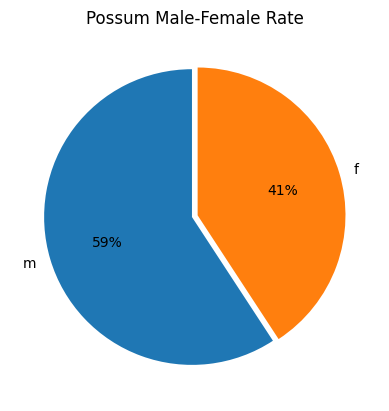

In [ ]:
plt.pie(possums['sex'].value_counts().values,labels=possums['sex'].value_counts().index,autopct="%1.0f%%",explode=(0.02, 0.02),startangle=90)
plt.title("Possum Male-Female Rate")
plt.show()
# классы сбалансированы

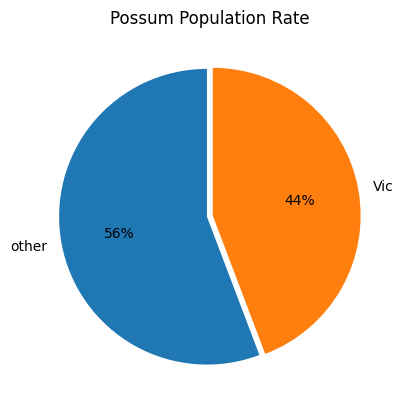

In [ ]:
plt.pie(possums['Pop'].value_counts().values,labels=possums['Pop'].value_counts().index,autopct="%1.0f%%",explode=(0.02, 0.02),startangle=90)
plt.title("Possum Population Rate")
plt.show()

<Axes: xlabel='Pop', ylabel='count'>

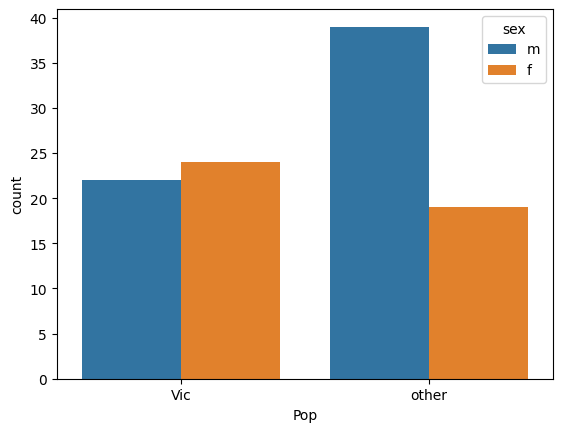

In [ ]:
sns.countplot(x = 'Pop', data = possums, hue='sex')
# в популяциях, не относящейся к озеру Виктория, количество самцов почти в два раза выше

In [ ]:
possums.drop(['case', 'age'], axis=1, inplace=True)
#удаление колонок с данными, которые не будут использоваться

In [ ]:
possums.dropna(inplace=True)
#удаление строк с пропущенными значениями

In [ ]:
possums['site'].value_counts()
#всего 7 участков, где были выловлены оппосумы

1    33
7    18
5    13
6    13
2    12
3     7
4     7
Name: site, dtype: int64

In [ ]:
possums.describe()

,site,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.0000,103.000000
mean,3.640777,92.643689,56.882524,87.128155,37.014563,68.459223,48.206796,15.037864,27.0000,32.606796
std,2.355030,3.566392,3.128629,4.312486,1.968448,4.395306,4.055310,1.052086,2.0556,2.767680
min,1.000000,82.500000,50.000000,75.000000,32.000000,60.300000,41.300000,12.800000,22.0000,25.000000
25%,1.000000,90.700000,54.950000,84.000000,35.750000,64.600000,44.850000,14.400000,25.5000,31.000000
50%,3.000000,92.800000,56.300000,88.000000,37.000000,68.000000,46.800000,14.900000,27.0000,32.500000
75%,6.000000,94.750000,58.100000,90.000000,38.000000,72.500000,52.000000,15.700000,28.0000,34.250000
max,7.000000,103.100000,68.600000,96.500000,43.000000,77.900000,56.200000,17.800000,32.0000,40.000000


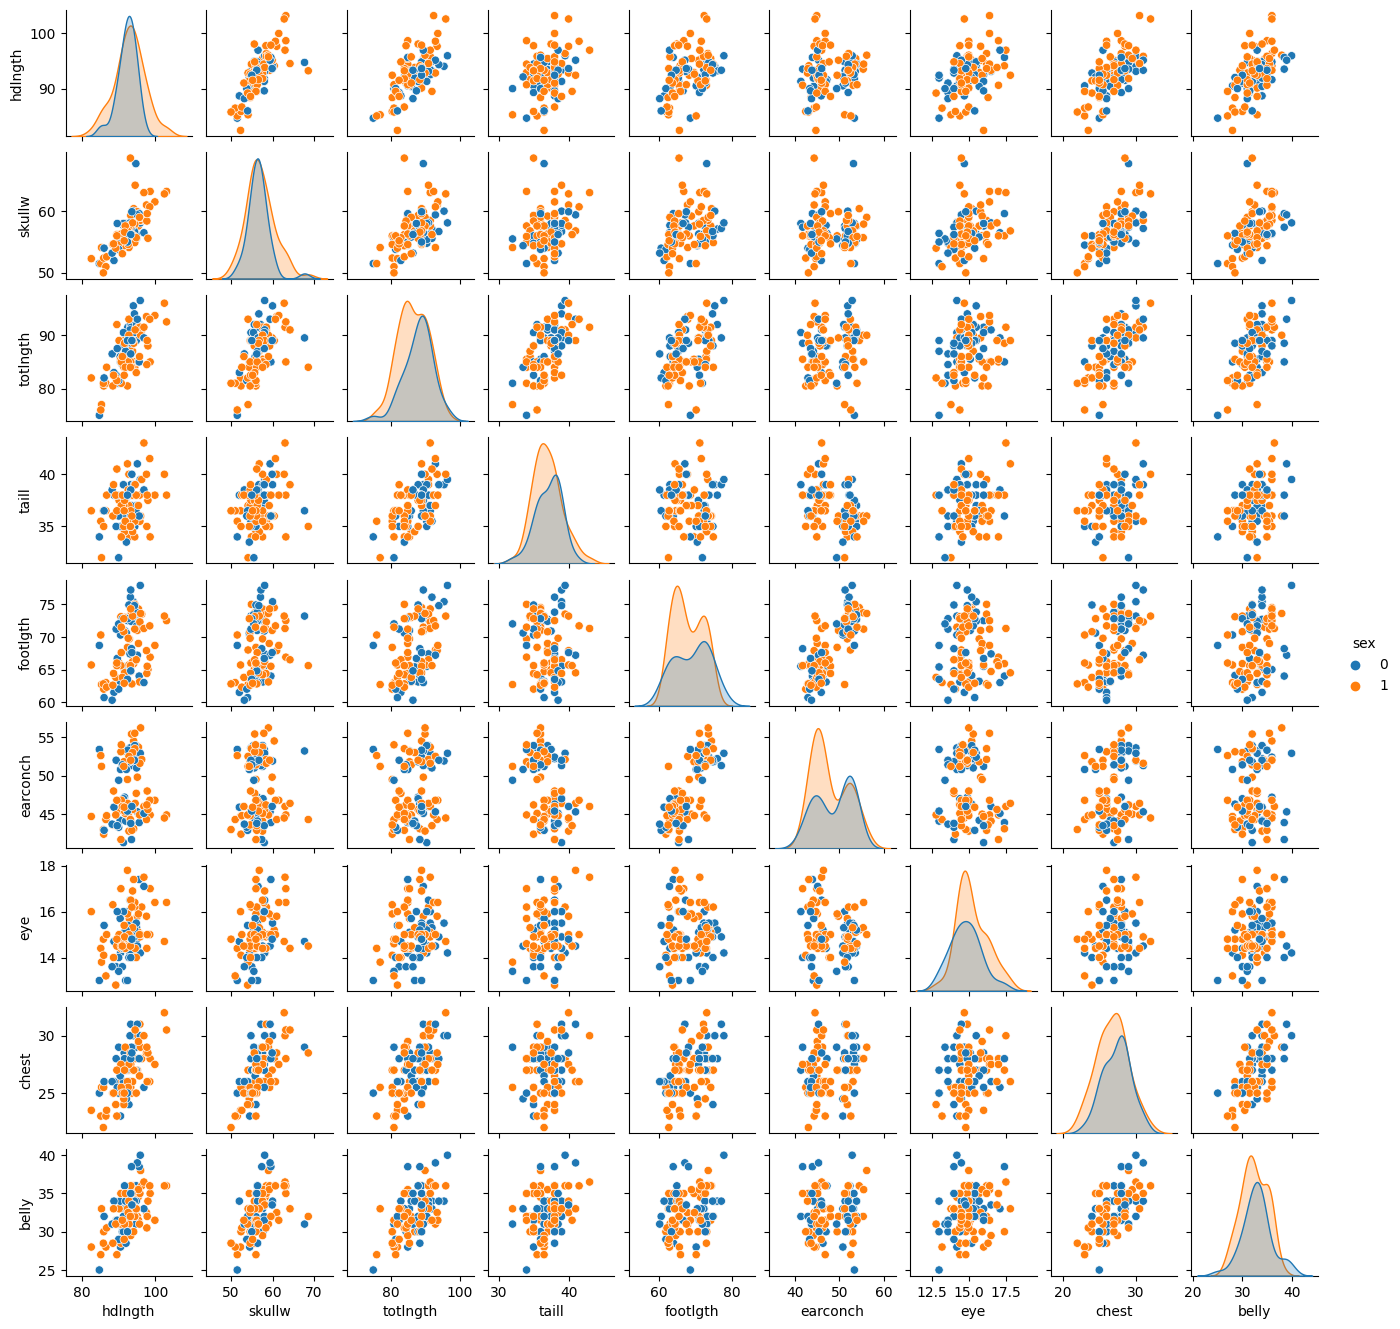

In [ ]:
sns.pairplot(possums, height=1.5, hue='sex')
#у многих признаков видны заметные выбросы, в распределениях явного разделения самцов и самок не наблюдается

<ipython-input-14-15fb8b20ee1a>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(possums.corr(), annot=True)


<Axes: >

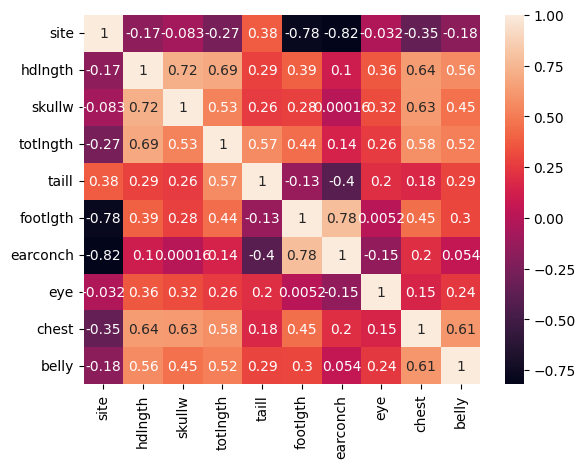

In [ ]:
sns.heatmap(possums.corr(), annot=True)
# есть сильная корелляция признаков earconch и footlgth, нужно будет оставить только один

In [ ]:
feature_list = ['site', 'hdlngth', 'skullw', 'totlngth', 'taill', 'footlgth', 'earconch', 'eye', 'chest', 'belly']
#переменная список признаков, пригодится для последующего анализа

# Выбросы


In [ ]:
# при EDA было видно, что данные имеют выбросы, есть вероятность, что это они мешают построить надежную модель
# создана копия датасета для работы с выбросами, поскольку чать данных будет потеряна
possums_clean = possums.copy()
possums_clean

,site,Pop,sex,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,Vic,m,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,1,Vic,f,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,1,Vic,f,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,1,Vic,f,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,1,Vic,f,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...
99,7,other,m,89.5,56.0,81.5,36.5,66.0,46.8,14.8,23.0,27.0
100,7,other,m,88.6,54.7,82.5,39.0,64.4,48.0,14.0,25.0,33.0
101,7,other,f,92.4,55.0,89.0,38.0,63.5,45.4,13.0,25.0,30.0
102,7,other,m,91.5,55.2,82.5,36.5,62.9,45.9,15.4,25.0,29.0


In [ ]:
def low_up(df, col):
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = iqr(df[col])
  lower_bound = Q1 - (1.5 * IQR)
  upper_bound = Q3 + (1.5 * IQR)
  return (lower_bound, upper_bound, Q1, Q3)

#функция, определяющая верхнюю и нижнюю границы выбросов (по формуле Q1/Q3 +_ 1.5 МКР)

In [ ]:
for i in feature_list:
  l_u = low_up(possums_clean, i)
  print(f"Feature {i}")
  print(f"lower outliers\n {possums_clean[(possums_clean[i]<= l_u[0])]}")
  possums_clean[i].loc[(possums_clean[i]<= l_u[0])]=l_u[0]
  print(f"Replaced to lower bond: {l_u[0]}")
  #заменяем нижние выбросы на нижнюю границу
  print(f"Feature {i}")
  print(f"upper outliers\n {possums_clean[(possums_clean[i]>= l_u[1])]}")
  print(f"Replaced to upper bond: {l_u[1]}")
  possums_clean[i].loc[possums_clean[i]>= l_u[1]]=l_u[1]
  #заменяем верхние выбросы на нижнюю границу

#границы для выбросов определяются отдельно для кажого признака, всего было преобразовано около 10% данных)
#принты, чтобы убедиться, что код работает корректно

In [ ]:
possums_clean.head(40)
# верхние/нижние выбросы заменились на верхнюю/нижнюю границу МКР соответственно

fig, ax = plt.subplots(1, 2, figsize=(7, 2))
top10 = df[['country','health']].sort_values('health', ascending = False).head(5)
bottom10 = df[['country','health']].sort_values('health', ascending = True).head(5)
plt1 = sns.barplot(x='health', y='country', data= top10, ax=ax[0])
plt2 = sns.barplot(x='health', y='country', data= bottom10, ax=ax[1])
plt1.set(xlabel = '', ylabel= 'Per capita health spendings')
plt2.set(xlabel = '', ylabel= 'Per capita health spendings')
plt.tight_layout()

In [ ]:

sns.pairplot(possums_clean, height=1.5, hue='sex')

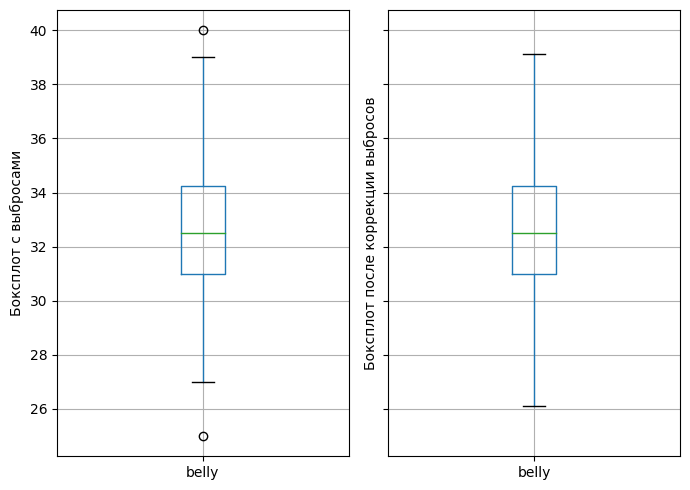

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(7, 5), sharey=True)
plt1 = possums.boxplot(column = ['belly'], ax=ax[0])
plt2 = possums_clean.boxplot(column = ['belly'], ax=ax[1])
plt1.set(xlabel = '', ylabel= 'Боксплот с выбросами')
plt2.set(xlabel = '', ylabel= 'Боксплот после коррекции выбросов')
fig.align_labels()
plt.tight_layout()

#сравнениюе двух боксплотов для одного признака с выбросами и без, распределение данных поменялось

In [ ]:
possums_clean.isnull().sum()


site         0
sex          0
hdlngth      0
skullw       0
totlngth     0
taill        0
footlgth     0
earconch     0
eye          0
chest        0
belly        0
Pop_other    0
dtype: int64

In [ ]:
for i in feature_list:
  print(i, stats.mannwhitneyu(x=possums.loc[possums['sex']=='f'][i], y=possums.loc[possums['sex']=='m'][i]))
#сравнение с использованием критерия манна-уитни (поскольку явно видно, что некоторые признаки распределены ненормально (статистически значимых различий не обнаружено)

site MannwhitneyuResult(statistic=927.0, pvalue=0.015234118306245655)
hdlngth MannwhitneyuResult(statistic=1123.0, pvalue=0.29045782809778287)
skullw MannwhitneyuResult(statistic=1195.0, pvalue=0.5659617091573137)
totlngth MannwhitneyuResult(statistic=1551.5, pvalue=0.06963678748946707)
taill MannwhitneyuResult(statistic=1420.0, pvalue=0.34939128808536146)
footlgth MannwhitneyuResult(statistic=1444.0, pvalue=0.2754281772326861)
earconch MannwhitneyuResult(statistic=1429.0, pvalue=0.3221479240412023)
eye MannwhitneyuResult(statistic=1008.5, pvalue=0.06758628553358473)
chest MannwhitneyuResult(statistic=1504.5, pvalue=0.13247532165285986)
belly MannwhitneyuResult(statistic=1417.0, pvalue=0.36160145566532)


# Кодирование и отбор признаков

In [ ]:
possums_clean = pd.get_dummies(possums_clean, columns=['Pop'], drop_first=True)
possums_clean.head(5)

,site,sex,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly,Pop_other
0,1.0,m,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0,0
1,1.0,f,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0,0
2,1.0,f,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0,0
3,1.0,f,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0,0
4,1.0,f,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0,0


In [ ]:
possums_clean.columns

Index(['sex', 'hdlngth', 'skullw', 'totlngth', 'taill', 'footlgth', 'earconch',
       'eye', 'chest', 'belly', 'Pop_Vic', 'Pop_other'],
      dtype='object')

In [ ]:
possums_clean_features = ['site', 'hdlngth', 'totlngth', 'earconch', 'footlgth',
       'eye', 'chest', 'Pop_other']
# K_best =['totlngth', 'footlgth', 'earconch', 'eye', 'chest', 'Pop_Vic', 'Pop_other']

In [ ]:
features = ['site', 'hdlngth', 'skullw', 'totlngth', 'taill', 'footlgth', 'earconch',
       'eye', 'chest', 'belly', 'Pop_other']
X = possums_clean[features]
y = possums_clean['sex']

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

TOP_FEATURES = 11

forest = ExtraTreesClassifier(n_estimators=250, max_depth=5, random_state=1)
forest.fit(X, y)

importances = forest.feature_importances_
list_imp = []

for ind, fea in zip(features, importances):
  list_imp.append((ind, fea))
list_imp.sort(key=lambda x: x[1], reverse=True)
list_imp
#отсортированный список важности признаков

[('footlgth', 0.1182832365149894),
 ('eye', 0.11660269665655557),
 ('site', 0.1095419596425781),
 ('hdlngth', 0.10898430135682757),
 ('totlngth', 0.09294060382407625),
 ('belly', 0.09265112130413726),
 ('skullw', 0.08084331558028716),
 ('chest', 0.0779758987403525),
 ('earconch', 0.07411412718663739),
 ('taill', 0.07270950464099349),
 ('Pop_other', 0.05535323455256536)]

In [ ]:
tree_selected_features = ['site', 'hdlngth', 'totlngth', 'footlgth',
       'eye', 'belly']

In [ ]:
# разбиваем выборку на обучающую и тестовую, чтобы все преобразования подгонять на обучающей
X = possums_clean[possums_clean_features]
# X = possums_clean[K_best]
# X = possums_clean[tree_selected_features]

#признаки отобраны на основании теста Манна-Уитни

y = possums_clean['sex']
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(possums_clean['sex'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [ ]:
y
# пол закодирован

array([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0])

In [ ]:
prediction_decoded = labelencoder.inverse_transform(y)
print(prediction_decoded)
# пол в исходном виде, посмотреть какой лэйбл какому полу соответствует

['m' 'f' 'f' 'f' 'f' 'f' 'm' 'f' 'f' 'f' 'f' 'f' 'm' 'm' 'm' 'm' 'f' 'm'
 'f' 'f' 'f' 'm' 'f' 'm' 'm' 'm' 'f' 'm' 'f' 'f' 'm' 'f' 'm' 'm' 'm' 'm'
 'f' 'm' 'f' 'f' 'm' 'f' 'm' 'm' 'm' 'm' 'm' 'm' 'f' 'f' 'm' 'f' 'm' 'm'
 'm' 'f' 'm' 'm' 'f' 'm' 'f' 'f' 'f' 'f' 'f' 'm' 'm' 'm' 'f' 'm' 'm' 'm'
 'f' 'm' 'm' 'm' 'm' 'm' 'm' 'm' 'f' 'f' 'm' 'm' 'f' 'm' 'f' 'm' 'm' 'm'
 'm' 'm' 'm' 'm' 'm' 'm' 'm' 'f' 'm' 'm' 'f' 'm' 'f']


In [ ]:
X_train


,site,hdlngth,skullw,totlngth,footlgth,eye,belly
71,5.0,85.900,52.4,80.5,62.0,14.1,30.0
60,5.0,95.700,59.0,86.0,63.1,15.0,31.0
21,1.0,96.300,58.5,91.0,73.5,16.2,36.0
72,5.0,84.625,52.3,82.0,65.7,16.0,28.0
6,1.0,95.300,58.2,89.5,71.5,14.2,34.5
...,...,...,...,...,...,...,...
28,1.0,92.800,56.0,88.0,74.9,14.0,32.0
65,5.0,90.400,55.8,86.0,63.2,15.7,34.0
15,1.0,91.600,56.0,86.0,73.0,14.4,32.0
101,7.0,92.400,55.0,89.0,63.5,13.0,30.0


In [ ]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

num_cols = ['hdlngth', 'totlngth', 'earconch', 'footlgth',
       'eye', 'chest']
# num_cols = tree_selected_features


for i in num_cols:
  scaler = StandardScaler().fit(X_train_scaled[[i]])
  X_train_scaled[i] = scaler.transform(X_train_scaled[[i]])
  X_test_scaled[i] = scaler.transform(X_test_scaled[[i]])
# X_test = scaler.transform(X_test)
# X_train = pd.DataFrame(X_train, columns=col_names)
# X_test = pd.DataFrame(X_test, columns=col_names)
X_train_scaled

,site,hdlngth,totlngth,earconch,footlgth,eye,chest,Pop_other
71,5.0,-2.035445,-1.620682,-1.478956,-1.521011,-1.059995,-0.754097,1
60,5.0,0.805875,-0.323708,-0.871922,-1.268701,-0.180789,-0.256748,1
21,1.0,0.979834,0.855360,0.876337,1.116778,0.991485,0.489275,0
72,5.0,-2.405107,-1.266962,-0.920485,-0.672331,0.796106,-1.748795,1
6,1.0,0.689903,0.501640,0.852055,0.658032,-0.962305,1.483973,0
...,...,...,...,...,...,...,...,...
28,1.0,-0.034923,0.147919,0.803493,1.437901,-1.157685,-1.500121,0
65,5.0,-0.730757,-0.323708,-1.041891,-1.245763,0.503038,-0.256748,1
15,1.0,-0.382840,-0.323708,0.706367,1.002092,-0.766926,0.489275,0
101,7.0,-0.150896,0.383733,-0.750515,-1.176952,-2.134580,-1.002772,1


In [ ]:
X_train_scaled.describe()

,site,hdlngth,footlgth,eye
count,7.700000e+01,7.700000e+01,7.700000e+01,7.700000e+01
mean,-1.038131e-16,-6.524363e-16,2.308399e-15,-3.032207e-15
std,1.006557e+00,1.006557e+00,1.006557e+00,1.006557e+00
min,-1.084545e+00,-2.405107e+00,-1.635698e+00,-2.134580e+00
25%,-1.084545e+00,-4.408264e-01,-9.017040e-01,-6.692368e-01
50%,-2.410100e-01,8.104880e-02,-5.302389e-02,-1.807891e-01
75%,1.024292e+00,5.449379e-01,9.332800e-01,6.984168e-01
max,1.446060e+00,2.291770e+00,2.126020e+00,2.407984e+00


#LogRegression

In [ ]:
lr_model = LogisticRegression(random_state=18)

In [ ]:
lr_model = lr_model.fit(X_train_scaled, y_train)
y_pred = lr_model.predict(X_test_scaled)


In [ ]:
y_pred

array([0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1])

<Axes: >

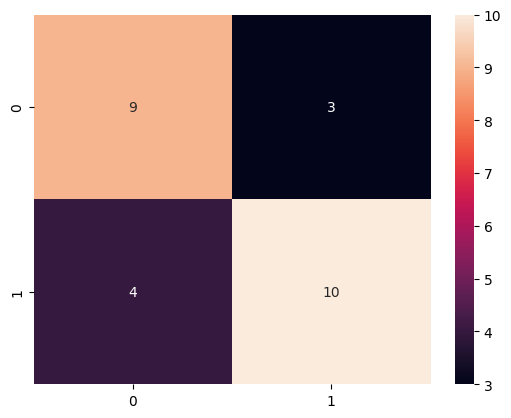

In [ ]:
# visualisation
con_mat = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(con_mat, fmt='', annot=True)

In [ ]:
print(classification_report(y_test, lr_model.predict(X_test_scaled)))
#у модели не очень высокие показатели эффективности

              precision    recall  f1-score   support

           0       0.69      0.75      0.72        12
           1       0.77      0.71      0.74        14

    accuracy                           0.73        26
   macro avg       0.73      0.73      0.73        26
weighted avg       0.73      0.73      0.73        26



<Axes: >

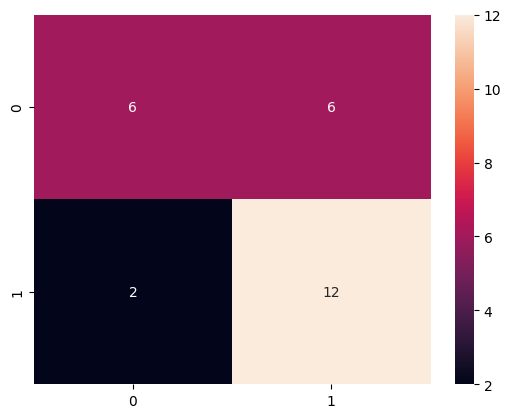

In [ ]:
kn = KNeighborsClassifier(n_neighbors=7)
knmodel = kn.fit(X_train_scaled,y_train)
y_pred = knmodel.predict(X_test_scaled)
con_mat = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(con_mat, fmt='', annot=True)

In [ ]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.75      0.50      0.60        12
           1       0.67      0.86      0.75        14

    accuracy                           0.69        26
   macro avg       0.71      0.68      0.68        26
weighted avg       0.71      0.69      0.68        26



## Оtбор признаков на основании Importance

In [ ]:
importance = lr_model.coef_[0]
importance

array([ 0.64251734,  0.38733888, -0.78311858,  0.24885169,  0.41793797,
       -0.28135981, -0.33926581, -0.25848954])

Feature: hdlngth, Score: 0.6425173420290368
Feature: skullw, Score: 0.38733887581546095
Feature: totlngth, Score: -0.7831185809841973
Feature: footlgth, Score: 0.2488516909230749
Feature: eye, Score: 0.4179379717062713
Feature: chest, Score: -0.28135980667972466
Feature: belly, Score: -0.3392658098153351
Feature: Pop_Vic, Score: -0.258489536306289


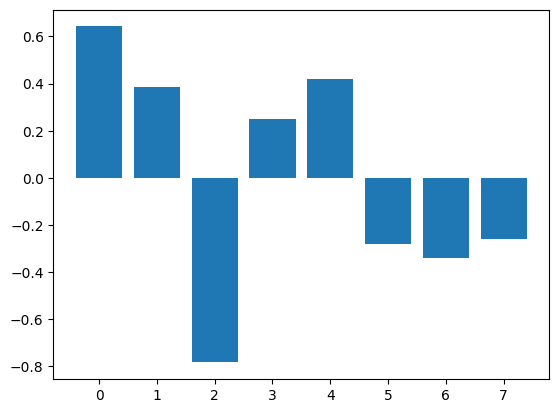

In [ ]:
for i,v in zip(possums_clean_features, importance):
 print(f'Feature: {i}, Score: {v}')
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()
#этот график менялся в зависимости от признаков, добавленных в модель, признак с наименьшей важностью исключался по одному
#данный подход оказался неэффективным и не использован

# Feature engineering/selection

## полиномиальные признаки

In [ ]:
# генерируем полиномиальные признаки
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)
print(X_train_scaled_poly.shape)
print(X_test_scaled_poly.shape)

(77, 44)
(26, 44)


In [ ]:
#создаем модель и делаем прогноз
lr_model_scaled_poly = LogisticRegression()
lr_model_scaled_poly = lr_model_scaled_poly.fit(X_train_scaled_poly, y_train)
y_pred_scaled_poly = lr_model_scaled_poly.predict(X_test_scaled_poly)

In [ ]:
print(metrics.classification_report(y_test, y_pred_scaled_poly))
#метрики стали хуже

              precision    recall  f1-score   support

           0       0.54      0.58      0.56        12
           1       0.62      0.57      0.59        14

    accuracy                           0.58        26
   macro avg       0.58      0.58      0.58        26
weighted avg       0.58      0.58      0.58        26



##selection

In [ ]:
from sklearn.feature_selection import SelectKBest


In [ ]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X_af = possums_clean.drop('sex', axis=1)
y_af = possums_clean['sex']
X_new = SelectKBest(f_classif, k=7).fit_transform(X_af, y_af)
X_new

In [ ]:
X_new
#алгоритм выбрал 'totlngth' и 'eye', я попробовала обучить самую успешную модель по этим признакам, в итоге метрики получились плохие

#Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score

In [ ]:
features = ['site', 'hdlngth', 'skullw', 'totlngth', 'taill', 'footlgth', 'earconch',
       'eye', 'chest', 'belly', 'Pop_other']


In [ ]:
X = possums_clean[features]
# X = possums_clean[tree_selected_features]
y = possums_clean['sex']

y = possums_clean['sex']
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(possums_clean['sex'])

In [ ]:
y

array([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0])

In [ ]:
# #X,y из логрег модели, с теми признаками, что отработали там лучше всего
# # разбиваем исходную выборку на тренировочную и валидационную в соотношении 80/20
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)
# # разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
# X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=1)

In [ ]:
# print(f'Размерность тренировочной выборки: {X_train.shape}')
# print(f'Размерность валидационной: {X_valid.shape}')
# print(f'Размерность тестовой: {X_test.shape}')

Размерность тренировочной выборки: (82, 6)
Размерность валидационной: (10, 6)
Размерность тестовой: (11, 6)


При разбивке на три выборки, набор данных становится слишком малым, и все метрики нестабильным, нужно будет применять другой метод валидации, который подходит для небольших датасетов

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


In [ ]:
X_train

,site,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly,Pop_other
82,6,90.0,53.8,81.5,36.0,62.0,43.3,14.0,25.0,29.0,1
83,6,88.4,54.6,80.5,36.0,62.6,43.6,16.3,25.0,28.5,1
33,2,90.6,55.7,85.5,36.5,73.1,53.1,14.4,26.0,28.5,0
57,4,94.5,64.2,91.0,39.0,66.5,46.4,14.4,30.5,33.0,1
84,6,89.5,56.2,92.0,40.5,65.6,43.5,14.5,27.0,31.5,1
...,...,...,...,...,...,...,...,...,...,...,...
76,6,93.6,56.2,84.0,36.0,62.8,42.9,16.2,25.0,35.0,1
9,1,91.8,58.0,89.5,37.5,70.9,53.4,14.4,27.5,32.0,0
73,6,88.7,52.0,83.0,38.0,61.5,45.9,14.7,26.0,34.0,1
12,1,95.1,59.9,89.5,36.0,71.0,49.8,15.8,27.0,32.0,0


In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, y_pred))
# если менять random state, то метрики меняются очень сильно из-за того что выборка  очень маленькая, нужно будет использовать другой метод кросс валидации

              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.75      0.82      0.78        11

    accuracy                           0.76        21
   macro avg       0.76      0.76      0.76        21
weighted avg       0.76      0.76      0.76        21



##Cross validation

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
rfc=RandomForestClassifier(random_state=10)


In [ ]:
param_grid = {
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [ ]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

In [ ]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 200}

In [ ]:
rfc_tuned = RandomForestClassifier(random_state=13, criterion='entropy', max_depth=7, max_features='auto', n_estimators= 200)

In [ ]:
rfc_tuned.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(criterion='entropy', max_depth=7, max_features='auto',
                       n_estimators=200, random_state=13)

In [ ]:
y_pred = rfc_tuned.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.62      0.80      0.70        10
           1       0.75      0.55      0.63        11

    accuracy                           0.67        21
   macro avg       0.68      0.67      0.66        21
weighted avg       0.69      0.67      0.66        21



In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn import model_selection


In [ ]:
# Leave-One-Out валидация
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    random_state=42, #генератор случайных чисел
    n_estimators= 200
)

# Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=82)

# Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X_train, #матрица наблюдений X
    y=y_train, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
cv_metrics

{'fit_time': array([0.30782366, 0.39329052, 0.47985744, 0.47880125, 0.47791767,
        0.48020244, 0.48782086, 0.48501468, 0.50187898, 0.47423816,
        0.28044963, 0.27627277, 0.27975345, 0.2872169 , 0.28904986,
        0.27855301, 0.29038501, 0.28591275, 0.27453017, 0.29243541,
        0.28266644, 0.27891278, 0.27428961, 0.2927146 , 0.27822137,
        0.27671432, 0.29275417, 0.28525734, 0.27488112, 0.2891171 ,
        0.28247309, 0.28591275, 0.2970233 , 0.30964947, 0.27790093,
        0.28448343, 0.30322886, 0.28978801, 0.2748282 , 0.29239774,
        0.28316784, 0.27599978, 0.45079041, 0.46623063, 0.49147844,
        0.47358465, 0.48347116, 0.47201896, 0.49873638, 0.48030949,
        0.38903689, 0.28958178, 0.27882242, 0.28270125, 0.30180645,
        0.28309274, 0.28574204, 0.29038692, 0.27327609, 0.28006244,
        0.29529548, 0.27354908, 0.27660179, 0.28384233, 0.28761864,
        0.28098679, 0.27992535, 0.2948606 , 0.27429628, 0.28333187,
        0.28862429, 0.27678537, 0.28

In [ ]:
print(f"Среднее качество на тренировочной выборке: {np.mean(cv_metrics['train_score']):.2f}")
print(f"Среднее качество на валидационной выборке: {np.mean(cv_metrics['test_score']):.2f}")

Среднее качество на тренировочной выборке: 1.00
Среднее качество на валидационной выборке: 0.65


Значение accuracy 0,66 в целом, в линию со всеми другими моделями, и, как мне кажется отражает качество модели.

#GradientBoostingClassifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gbcl=GradientBoostingClassifier(random_state=10)

In [ ]:
params = {
    'n_estimators': range(10, 40, 5),
    'max_depth': range(2, 10, 2)
}

In [ ]:
model = GridSearchCV(
    gbcl,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)

model.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=10),
             n_jobs=-1,
             param_grid={'max_depth': range(2, 10, 2),
                         'n_estimators': range(10, 40, 5)},
             verbose=1)

In [ ]:
model.best_params_

{'max_depth': 2, 'n_estimators': 10}

In [ ]:
y_pred = model.predict(X_test)

con_mat = confusion_matrix(y_test, y_pred)
con_mat

array([[3, 5],
       [5, 8]])

In [ ]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.38      0.38      0.38         8
           1       0.62      0.62      0.62        13

    accuracy                           0.52        21
   macro avg       0.50      0.50      0.50        21
weighted avg       0.52      0.52      0.52        21



In [ ]:
gbcl_tuned=GradientBoostingClassifier(random_state=10, max_depth=2, n_estimators=10)

In [ ]:
gbcl_tuned.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=2, n_estimators=10, random_state=10)

In [ ]:
y_pred = gbcl_tuned.predict(X_test)

con_mat = confusion_matrix(y_test, y_pred)
con_mat

array([[3, 5],
       [5, 8]])

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.38      0.38         8
           1       0.62      0.62      0.62        13

    accuracy                           0.52        21
   macro avg       0.50      0.50      0.50        21
weighted avg       0.52      0.52      0.52        21



In [ ]:
# Leave-One-Out валидация
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingClassifier(
    max_depth=2, #максимальная глубина
    random_state=42, #генератор случайных чисел
    n_estimators= 10
)

# Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=82)

# Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X_train, #матрица наблюдений X
    y=y_train, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
cv_metrics

{'fit_time': array([0.02518916, 0.02246284, 0.01533604, 0.01318765, 0.01972032,
        0.02401423, 0.02883458, 0.02815032, 0.03477359, 0.02744222,
        0.02421856, 0.02287698, 0.02989078, 0.02783966, 0.0284884 ,
        0.03177285, 0.02849483, 0.02627993, 0.03413582, 0.02844214,
        0.01931071, 0.03084707, 0.03648829, 0.03891277, 0.01822972,
        0.01440668, 0.02165031, 0.04204106, 0.03467965, 0.03427577,
        0.02147651, 0.01334214, 0.01297808, 0.01705408, 0.03074312,
        0.02733254, 0.02312231, 0.02425671, 0.02802467, 0.02810431,
        0.02728486, 0.0289228 , 0.02680159, 0.0207119 , 0.01682973,
        0.01340723, 0.0181632 , 0.0261333 , 0.02957535, 0.02060676,
        0.01453137, 0.02713895, 0.02965331, 0.02589226, 0.02119398,
        0.0274868 , 0.02889132, 0.03885007, 0.02854013, 0.02558756,
        0.03107142, 0.01419282, 0.01469445, 0.01423573, 0.01420116,
        0.01354599, 0.01237535, 0.01247334, 0.01233268, 0.01231241,
        0.01540971, 0.01243877, 0.01

In [ ]:
print(f"Среднее качество на тренировочной выборке: {np.mean(cv_metrics['train_score']):.2f}")
print(f"Среднее качество на валидационной выборке: {np.mean(cv_metrics['test_score']):.2f}")

Среднее качество на тренировочной выборке: 0.82
Среднее качество на валидационной выборке: 0.54


#Балансировка датасета

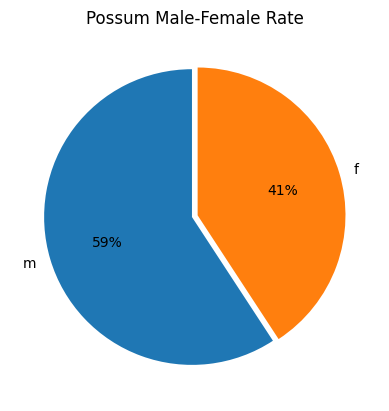

In [ ]:
plt.pie(possums['sex'].value_counts().values,labels=possums['sex'].value_counts().index,autopct="%1.0f%%",explode=(0.02, 0.02),startangle=90)
plt.title("Possum Male-Female Rate")
plt.show()
# классы сбалансированы

In [ ]:
from imblearn.over_sampling import SMOTE

X = possums_clean[possums_clean_features]
y = possums_clean['sex']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


sm = SMOTE(random_state=42)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

print(f'Размерность тренировочной выборки до сэмплирования: {X_train.shape}')
print(f'Баланс классов до сэмплирования:\n{y_train.value_counts()}')
print('-'*40)
print(f'Размерность тренировочной выборки после сэмплирования: {X_train_s.shape}')
print(f'Баланс классов после сэмплирования:\n{y_train_s.value_counts()}')

Размерность тренировочной выборки до сэмплирования: (82, 8)
Баланс классов до сэмплирования:
m    50
f    32
Name: sex, dtype: int64
----------------------------------------
Размерность тренировочной выборки после сэмплирования: (100, 8)
Баланс классов после сэмплирования:
m    50
f    50
Name: sex, dtype: int64


##посмотрим как будет работать сэмплированная выборка на бейзлайн модели

In [ ]:
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(possums_clean['sex'])

In [ ]:
X_train_scaled = X_train_s.copy()
X_test_scaled = X_test.copy()

num_cols = ['hdlngth', 'totlngth', 'earconch', 'footlgth',
       'eye', 'chest']
# num_cols = tree_selected_features


for i in num_cols:
  scaler = StandardScaler().fit(X_train_scaled[[i]])
  X_train_scaled[i] = scaler.transform(X_train_scaled[[i]])
  X_test_scaled[i] = scaler.transform(X_test_scaled[[i]])
# X_test = scaler.transform(X_test)
# X_train = pd.DataFrame(X_train, columns=col_names)
# X_test = pd.DataFrame(X_test, columns=col_names)
X_train_scaled

,site,hdlngth,totlngth,earconch,footlgth,eye,chest,Pop_other
0,3.000000,1.444724,1.530797,-0.923088,-0.025153,0.622288,0.769773,1
1,7.000000,-0.285776,-0.854663,-0.726942,-0.852279,-0.761491,1.038760,1
2,6.000000,-1.359879,-0.226910,-1.070197,-1.724115,-1.552221,-0.575162,1
3,6.000000,-2.016276,-1.356865,-1.266343,-1.634696,0.226922,-0.575162,1
4,3.000000,0.788327,-0.603562,-0.751460,0.220750,0.721129,1.307746,1
...,...,...,...,...,...,...,...,...
95,6.728181,-0.136496,0.378091,-0.617843,-1.016864,-2.019890,-1.064392,1
96,1.000000,0.376106,0.873318,1.337096,1.119051,0.142397,0.500786,0
97,5.764924,-0.372558,-0.304443,-0.985115,-0.939029,-0.119206,0.002457,1
98,3.033538,-0.343447,0.151847,-0.215760,-0.676815,-0.262312,0.478232,1


In [ ]:
lr_model_balanced = LogisticRegression(random_state=19, class_weight='balanced')


lr_model_balanced = lr_model_balanced.fit(X_train_scaled, y_train_s)
y_pred = lr_model_balanced.predict(X_test_scaled)

<Axes: >

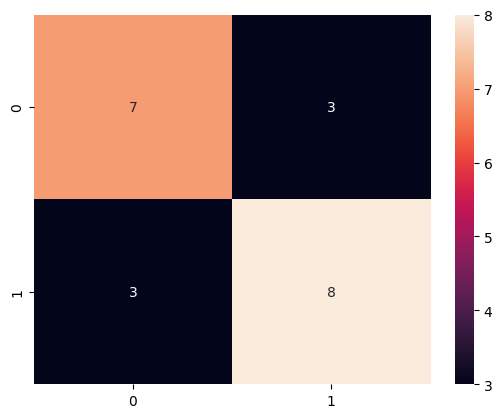

In [ ]:
# visualisation
con_mat = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(con_mat, fmt='', annot=True)

In [ ]:
print(classification_report(y_test, y_pred))
#результаты неплохие, лучше и сбалансированнее, чем при использовании ансамблевых методов

              precision    recall  f1-score   support

           f       0.70      0.70      0.70        10
           m       0.73      0.73      0.73        11

    accuracy                           0.71        21
   macro avg       0.71      0.71      0.71        21
weighted avg       0.71      0.71      0.71        21



## KNN с балансированной выборкой

<Axes: >

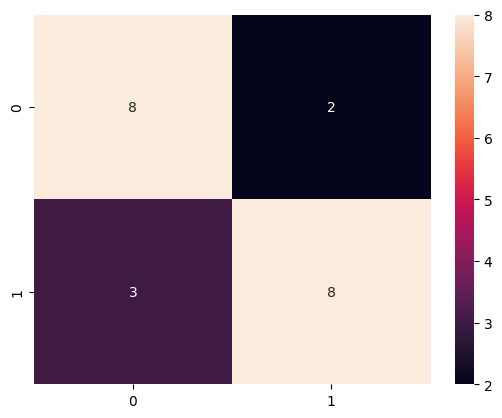

In [ ]:
kn = KNeighborsClassifier(n_neighbors=7)
knmodel = kn.fit(X_train_scaled,y_train_s)
y_pred = knmodel.predict(X_test_scaled)
con_mat = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(con_mat, fmt='', annot=True)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           f       0.73      0.80      0.76        10
           m       0.80      0.73      0.76        11

    accuracy                           0.76        21
   macro avg       0.76      0.76      0.76        21
weighted avg       0.77      0.76      0.76        21



#Stacking наиболее успешных моделей

In [ ]:
from sklearn.ensemble import StackingClassifier


In [ ]:
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('lr', LogisticRegression(max_iter=3000, random_state=10, class_weight='balanced')),
    ('dt',  RandomForestClassifier(random_state=10, criterion='entropy', max_depth=7, n_estimators=200)),
]

In [ ]:
# Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators, #базовые модели в стекинге
    final_estimator=LogisticRegression( #метамодель
        random_state=11
    )
)
# Обучаем модель
reg.fit(X_train_scaled, y_train_s)

StackingClassifier(estimators=[('lr',
                                LogisticRegression(class_weight='balanced',
                                                   max_iter=3000,
                                                   random_state=10)),
                               ('dt',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=7,
                                                       n_estimators=200,
                                                       random_state=10))],
                   final_estimator=LogisticRegression(random_state=11))

In [ ]:
y_pred = reg.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           f       0.70      0.70      0.70        10
           m       0.73      0.73      0.73        11

    accuracy                           0.71        21
   macro avg       0.71      0.71      0.71        21
weighted avg       0.71      0.71      0.71        21



In [ ]:
X_train_scaled.shape

(100, 8)

In [ ]:
# Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=100)

# Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=reg, #модель
    X=X_train_scaled, #матрица наблюдений X
    y=y_train_s, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
cv_metrics

{'fit_time': array([1.8179493 , 1.87916565, 3.11545563, 1.8074224 , 1.82023358,
        1.85534406, 1.80020499, 1.89511585, 2.58188605, 2.47881556,
        1.81378913, 1.80251265, 1.8117485 , 1.81317329, 1.86306047,
        3.04780412, 1.88259363, 1.83526897, 1.81876397, 1.79556656,
        1.81009388, 2.47755456, 2.5412643 , 1.81593013, 1.78291655,
        1.80900002, 1.8012042 , 1.78573966, 3.07152939, 2.13768363,
        1.81068611, 1.80310512, 1.81564307, 1.8183074 , 2.14920807,
        2.8222208 , 1.80035162, 1.8203814 , 1.81259847, 1.82542324,
        1.79897952, 2.71639562, 2.28532195, 1.81705379, 1.80966806,
        1.79212165, 1.82133317, 1.99711204, 2.99634457, 1.79219723,
        1.77882075, 1.80390906, 1.82398272, 1.83498573, 2.5459919 ,
        2.4865737 , 1.82547903, 1.8211658 , 1.81041026, 1.78795147,
        1.89302087, 3.05252337, 1.88093686, 1.79850268, 1.80159807,
        1.83340025, 1.81644058, 2.44131303, 2.60990882, 1.77933741,
        1.81121516, 1.79120398, 1.79

#Выводы

Были использованы модели Логистической регрессии, Случайного леса, Градиентного бустинга и KNN. Все они показали умеренное качество с метриками точности (accuracy) от 0,60 до 0,75. При валидации метрики были нестабильными, что я связываю с малым размером датасета (кажное правильно/неправильно) предсказанное значение/изменение random state меняло метрику на 5-10%. Лучше всего в итоге себя показала модель KNN и Стекинг Логистической регрессии и Random Forest (c подобранными гиперпараметрами)с балансировкой датасета. В качестве метода кросс-валидации был выбран Leave-One-Out из-за малого размера датасета.